In [1]:
# import python packages (these packages are preinstalled to Anaconda and Jupiter)

import gc
import glob, os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from scipy import stats
from scipy.interpolate import interp1d

In [3]:
!pip install pylatex # install pylatex package, if it was not installed before

     |████████████████████████████████| 92kB 4.9MB/s eta 0:00:011
  Created wheel for pylatex: filename=PyLaTeX-1.4.1-cp37-none-any.whl size=42815 sha256=92b589bc2afd00c98cdb0e6638ce48639f7854c357a8f3e277b198dd787d3cdb
  Stored in directory: /Users/samwise/Library/Caches/pip/wheels/a2/25/3a/2cc0a6219d95ce34f1f7439a6427c62ca262ebaeb5969db89f
  Created wheel for ordered-set: filename=ordered_set-4.0.2-py2.py3-none-any.whl size=8209 sha256=ead8a83a9bf51c3a0beaede0c3c264cf9916ff9c6e05a91e07992073ab611130
  Stored in directory: /Users/samwise/Library/Caches/pip/wheels/e1/c6/9b/651d8a21d59b51a75ab9c070838f9231b8126421bc0569af47
Successfully built pylatex ordered-set


In [4]:
# import nessesary function form pylatex 
from pylatex import Document, Section, Subsection, Command, Tabular,  Plot, Figure, SubFigure, NoEscape, Math  
from pylatex.utils import italic, bold 

In [5]:
# EDA information (print general EDA information or return it as a string, that will be used to generate pdf summary)
# the function declaration


def eda_general_information(df):

    """Given dataframe print general information about the data and dataframe. """

    # check that input is pandas dataframe
    if type(df) != pd.core.frame.DataFrame:
        raise TypeError("Only pandas dataframe is allowed as input")

    print('General information about the dataset \n')
    print('Number of unique id: ', df['id'].nunique())
    print('Data parameters :')
    print(df.columns.values)
    print('\nTypes of data elements:')
    print(df.dtypes)
    print('\nInformation about the dataframe: ')
    print(df.info())
    print('\nDataframe: ')
    print(df.head())
    print()

    print("\nDistribution of numeric data")
    print(df.describe().T)

    # generate preview of entries with null values
    if len(df[df.isnull().any(axis=1)] != 0):
        print("\nPreview of data with null values:")
        print(df[df.isnull().any(axis=1)].head(3))

    # generate count statistics of duplicate entries
    if len(df[df.duplicated()]) > 0:
        print("\n***Number of duplicated entries: ", len(df[df.duplicated()]))
        print(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).head())
    else:
        print("\nNo duplicated entries found")


def basic_info_str(df):

    """ Given dataframe saves basic eda information into string, return this string. """

    info = "1. The dataset contains following parameters: "
    for i, p in enumerate(df.columns.values):
        if i != 0:
            info += ', '
        info += str(p)
    info += ". \n\n"
    info += "2. The types of these parameters are "
    for i, d in enumerate(df.dtypes.values):
        if i != 0:
            info += ', '
        info += str(d)
    info += ". \n\n"

    info += "3. The number of unique id is " + str(df['id'].nunique()) + '. \n\n'

    if len(df[df.duplicated()]) > 0:
        info += "4. Number of duplicated entries is " + str(len(df[df.duplicated()])) + ".\n\n"
    else:
        info += "4. No duplicated entries found in dataset. \n\n" 

    return info

In [6]:
# Utilities that uses in several functions below 

def statistics(data):

    """Return mean and standard deviation of data in onedimentional array. """

    mean = sum(data) / len(data)
    std = sum([abs(data[i] - mean) for i in range(len(data))]) / len(data)
    return mean, std


def full_statistics(data):

    """Return mean and standard deviation, minimum and maximum of data in onedimentional array. """

    data = data[np.logical_not(np.isnan(data))]
    mean, std = statistics(data)
    return  [round(mean, 2), round(std, 2), round(min(data), 2), round(max(data), 2)]


In [7]:
# EDA plots 
# declaration of functions that plot time-series, distributions and histogram for numerical data in dataframe

def time_series_plot(df):

    """Given dataframe, generate times series plot of numeric data by daily, monthly and yearly frequency"""

    if len(df.select_dtypes(include='datetime64').columns)>0:
        for col in df.select_dtypes(include='datetime64').columns:
            for col_num in df.select_dtypes(include=np.number).columns:
                __ = df.copy()
                __ = __.set_index(col)
                __T = __[[col_num]]

                parameter = __T.columns.values[0]
                if parameter == 'id':
                    continue

                labels = ['By day', 'By month']
                colors = ['deepskyblue','blue']

                fig, ax = plt.subplots(1, 1, figsize = (12, 6))
                for i, p in enumerate(['D' ,'M']):
                    t = __T.resample(p, closed = 'left', label = 'left').mean()
                    plt.plot(t, linewidth = 2, label = labels[i], color = colors[i], zorder = i+1)
                               
                ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
                ax.set_ylabel(parameter, fontsize = 16, fontweight = 'bold')
                ax.set_xlabel('Time', fontsize = 16, fontweight = 'bold')

                plt.suptitle('Mean ' + parameter, fontsize = 20, fontweight = 'bold')
                ax.legend(fontsize = 14)
                ax.tick_params(axis='both', which='major', labelsize=10)

                fig.savefig(parameter + '.png', dpi = 300)
                plt.show()
                plt.close()


def plot_histograms(df, log = False, show_kde = False):

    """Given dataframe, plot histogram of numerical data distribution """

    if len(df.select_dtypes(include='datetime64').columns)>0:
        for col in df.select_dtypes(include='datetime64').columns:
            for col_num in df.select_dtypes(include=np.number).columns:
                __ = df.copy()
                __ = __.set_index(col)
                __T = __[[col_num]]

                name = parameter = __T.columns.values[0]
                if parameter == 'id':
                    continue

                t = __T.values[:, 0]
                t = t[np.logical_not(np.isnan(t))]

                fig, ax = plt.subplots(1, 1, figsize = (12, 6))
                if log == True:
                    name += '_log'
               
                if show_kde == True:
                    plt.hist(t, rwidth = 0.95, density = True, log = log, color = 'darkturquoise', alpha = 0.5)
                    kde = stats.gaussian_kde(t)
                    xx = np.linspace(min(t), max(t), 1000)
                    plt.plot(xx, kde(xx), color = 'tab:cyan', linewidth = 2)
                    name += '_kde'
                else:
                    plt.hist(t, rwidth = 0.95, density = True, log = log, color = 'darkturquoise')
                
                ax.set_ylabel('Frequency', fontsize = 16, fontweight = 'bold')
                ax.set_xlabel(parameter, fontsize = 16, fontweight = 'bold')

                plt.suptitle('Distribution of ' + parameter, fontsize = 20, fontweight = 'bold')
                ax.tick_params(axis='both', which='major', labelsize=12)

                fig.savefig(name + '_histogram.png', dpi = 300)
                plt.show()
                plt.close()


def plot_distribution_by_id(df, log = False, interpolate = False):
    
    """ Given dataframe, plot histogram of parameters distribution by id """

    if len(df.select_dtypes(include='datetime64').columns)>0:

        df2 = df.groupby('id').mean().reset_index()
        for col_num in df2.select_dtypes(include=np.number).columns:
            #for _ in range(1):

            __ = df2.copy()
            __T = __[[col_num]]
            __id = __[['id']]

            name = parameter = __T.columns.values[0]
            if parameter == 'id':
                continue

            t = __T.values[:, 0]
            id = __[['id']].values[:, 0]

            fig, ax = plt.subplots(1, 1, figsize = (12, 6))
            if log == True:
               name += '_log'
               
            if interpolate == True:
                plt.bar(id, t, color = 'violet', alpha = 0.5,  log = log)
                f = interp1d(id, t)
                xx = np.linspace(min(id), max(id), 1000)
                plt.plot(xx, f(xx), color = 'crimson', linewidth = 2)
                name += '_kde'
            else:
                plt.bar(id, t, color = 'crimson', log = log)

            ax.set_ylabel('Average ' + parameter, fontsize = 16, fontweight = 'bold')
            ax.set_xlabel('id', fontsize = 16, fontweight = 'bold')

            plt.suptitle('Distribution of average ' + parameter + ' by id ', fontsize = 20, fontweight = 'bold')
            ax.tick_params(axis='both', which='major', labelsize=12)

            fig.savefig(name + '_id_distribution.png', dpi = 300)
            plt.show()
            plt.close()
        
                
def plot_correlation_map(df):

    """Given the dataframe plot map of correlation between parameters. """

    corr = df.corr()
    labels = corr.columns.values
    corr = corr.values
    num = len(labels)

    # Heatmap of correlations
    fig, ax = plt.subplots(figsize = (6, 6))
    im = ax.imshow(corr, alpha = 0.5, cmap = 'gnuplot')

    ax.set_xticks(np.arange(num))
    ax.set_yticks(np.arange(num))
    ax.set_xticklabels(labels, fontsize = 16, fontweight = 'bold')
    ax.set_yticklabels(labels, fontsize = 16, fontweight = 'bold')

    for i in range(num):
        for j in range(num):
            text = ax.text(j, i, round(corr[i, j], 4), ha = 'center', va = 'center', color= 'black', fontsize = 16)

    fig.colorbar(im, ax = ax, orientation = 'vertical', shrink = 0.69)
    plt.title('Correlations Heatmap', fontsize = 16, fontweight = 'bold', pad = 10)
    fig.tight_layout() 

    fig.savefig('correlations.png', dpi = 300)
    plt.show()
    plt.close()

    
def range_box_plot(df):

    """Given dataframe, plot parameter range, mean and standard deviation. """

    columns = df.select_dtypes(include=np.number).columns
    L = len(columns)

    fig, axs = plt.subplots(1, L, figsize=(3*L, 5), sharey=False)
    for i, col in enumerate(columns):
        df2 = df.copy()
        data = df2[[col]] 
        parameter = data.columns.values[0]
        data = data.values[:, 0]
        data = data[np.logical_not(np.isnan(data))]
        mean, std = statistics(data)

        axs[i].bar(1, std, width = 0.5, bottom = mean-std, color = 'mediumturquoise', edgecolor = 'black', zorder = 2)
        axs[i].bar(1, std, width = 0.5, bottom = mean, color = 'mediumturquoise', edgecolor = 'black', zorder = 2)
        axs[i].errorbar(1, mean-std, yerr = [[mean-std-min(data)], [0]], capsize=40, linewidth = 2, color = 'black', zorder = 1)
        axs[i].errorbar(1, mean+std, yerr = [[0], [max(data)-mean-std]], capsize=40, linewidth = 2, color = 'black', zorder = 1)

        axs[i].set_ylabel(parameter, fontsize = 16, fontweight = 'bold')
        axs[i].axes.get_xaxis().set_visible(False)

    plt.tick_params(axis='both', which='major', labelsize=14)
    fig.tight_layout()
    
    fig.savefig('boxplots.png', dpi = 300)
    plt.show()
    plt.close()
    

def plot_joint_parameters_distribution(df):

    """ Description """

    columns = df.select_dtypes(include=np.number).columns
    L = len(columns)

    fig, axs = plt.subplots(L, L, figsize=(3*L, 3*L))
    for i, col1 in enumerate(columns):
        for j, col2 in enumerate(columns):
            _d1 = df[[col1]] 
            parameter1 = _d1.columns.values[0]
            _d2 = df[[col2]]
            parameter2 = _d2.columns.values[0]
            _d1 = _d1.values[:, 0]      
            d1 = _d1[np.logical_not(np.isnan(_d1))]

            if i < j:
                _d2 = _d2.values[:, 0]
                _d2 = _d2[np.logical_not(np.isnan(_d1))]
                d2 = _d2[np.logical_not(np.isnan(_d2))]
                d1 = d1[np.logical_not(np.isnan(_d2))]
             
                matrix = np.histogram2d(d1, d2, bins = 100, density = True)[0]
                matrix = matrix.T
                axs[j, i].imshow(matrix, norm = LogNorm(), cmap = 'plasma', interpolation = 'gaussian')

            if i==j:
                axs[j, i].hist(d1, rwidth = 0.9, bins = 20, density = True, color = 'rebeccapurple')
            if i > j:
                axs[j, i].axis('off')

            if i == 0:
                axs[j, i].set_ylabel(parameter2, fontsize = 14, fontweight = 'bold')
            else:
                axs[j, i].axes.get_yaxis().set_visible(False)
            if j == L-1:
                axs[j, i].set_xlabel(parameter1, fontsize = 14, fontweight = 'bold')
            else:
                axs[j, i].axes.get_xaxis().set_visible(False)

    plt.subplots_adjust(wspace = 0.1, hspace = 0.1)
    plt.suptitle('Distirubution of Numeric Parameters', fontsize = 16, fontweight = 'bold', y = 0.93)

    fig.savefig('joint_distribution.png', dpi = 300)
    plt.show()
    plt.close()


In [8]:
# Function that saves EDA information and plots to pdf file
# To run this function, first running of all plot-function is need 
# To generate pdf-file the script automatically calls MikTex. 
# MikTex is a free program that can be dowload from the link below form the official site
# https://miktex.org/download

def pdf_summary(df):
    
    parameters = df.select_dtypes(include=np.number).columns.values

    geometry_options = {"right": "2cm", "left": "2cm", "top": "2cm", "bottom" : "2cm"}
    doc = Document('summary', geometry_options=geometry_options)

    doc.preamble.append(Command('title', bold('Exploratory Data Analysis')))
    doc.append(NoEscape(r'\maketitle'))

    with doc.create(Section('Preliminary Data Processing')):
        doc.append(NoEscape(r'\vspace{0.5cm}'))
        doc.append(basic_info_str(df))

        with doc.create(Figure(position='h!')) as param_range:
            param_range.add_image('boxplots.png', width=NoEscape(r'\linewidth'))
            param_range.add_caption('Parameters ranges: the mean value plus and minus standard deviation are shown by boxes, minimal and maximal values -- by errorbars.')

        #doc.append("\n\n")

        doc.append(NoEscape(r'\pagebreak'))
        doc.append(NoEscape(r'\noindent'))
        doc.append(bold("General statistics of dataset parameters: "))
        doc.append("\n\n")

        with doc.create(Tabular(table_spec='|c|r|r|r|r|', data=None, pos='h!', row_height = 1.5)) as tab:
            tab.add_hline()
            tab.add_row (('Parameter', 'Mean', 'Standard deviation', 'Minimum', 'Maximum'), mapper = bold)
            tab.add_hline()
            for param in parameters:
                tab.add_hline()
                tab.add_row([param] + full_statistics(df[[param]].values[:, 0]))
            tab.add_hline()

        parameters = parameters[:-1]

        doc.append(NoEscape(r'\vspace{0.5cm}'))
        doc.append("\n\n")
        doc.append(NoEscape(r'\noindent'))
        doc.append(bold("Correlation between the data parameters: \n\n"))

        doc.append("The correlation is very weak if the correlation coefficient lie in the range 0 -- 0.19, weak:  0.20 - 0.39, moderate: 0.40-- 0.59, strong: 0.60 -- 0.79, very strong: 0.80 -- 1.0.")
        doc.append("\n")
        #doc.append(NoEscape(r'\vspace{0.5cm}'))
        
        with doc.create(Figure(position='h!')) as corr_plot:
            corr_plot.add_image('correlations.png', width=NoEscape(r'0.7\linewidth'))
            corr_plot.add_caption('Correlation between parameters (the id of data file is also considered). \
            The correlation coefficient of each paramaters pair is shown in the cell of these parsmeters junction.')

        
    doc.append(NoEscape(r'\pagebreak'))

    with doc.create(Section("Distribution of parameter's values")):
        with doc.create(Subsection('Time-series plots')):
            doc.append('The time-series plots demonstrates how parameters of dataset change with time.\
            These are avereged by one day and one month to show general dynamics of parameters .')
            doc.append(NoEscape(r'\vspace{0.5cm}'))

            series_plot_names = ['eload.png', 'Temp.png']
            with doc.create(Figure(position='h!')) as timeseries_plot: 
                for i, plot in enumerate(series_plot_names):
                    if i != 0:
                        doc.append("\n")
                        doc.append("\n")
                    with doc.create(SubFigure(position='b', width=NoEscape(r'1\linewidth'))) as temp:
                        temp.add_image(plot, width=NoEscape(r'\linewidth'))
                timeseries_plot.add_caption('Time-series paramters dependence on time, values sre averaged by day and by month.')

        doc.append(NoEscape(r'\pagebreak'))

        with doc.create(Subsection("The frequency of parameter's values")):
            doc.append('The histograms below shows how frequent are each given value of dataset parameters. ')
            doc.append(NoEscape(r'\vspace{0.5cm}'))

            def hist_names(param, log = False):
                if log == True:
                    return [param + '_log_histogram.png', param + '_log_kde_histogram.png']
                return [param + '_histogram.png', param + '_kde_histogram.png']

            histograms = [[], []]
            for i, param in enumerate(parameters):
                histograms[0] += hist_names(param, log = False)
                histograms[1] += hist_names(param, log = True)

            captions = ['Left panel: histograms of parameters distributions. Right panel: histograms with kernal\
            density estimation of parameter distribution density is shown by a solid line.', \
                'Same as Figure 3, but in logarithmic scale.']

            for j in range(2):
                with doc.create(Figure(position='h!')) as histogram_plot: 
                    for i, plot in enumerate(histograms[j]):
                        if i != 0 and i%2 == 0:
                            doc.append("\n")
                        with doc.create(SubFigure(position='b', width=NoEscape(r'0.5\linewidth'))) as temp:
                            temp.add_image(plot, width=NoEscape(r'\linewidth'))
                    histogram_plot.add_caption(captions[j])
                doc.append(NoEscape(r'\vspace{0.5cm}'))

        doc.append(NoEscape(r'\pagebreak'))

        with doc.create(Subsection("Parameters dependence on id")):
            doc.append('The following histograms demonstrates the average values of dataset parameters within one data file.  ')
            doc.append(NoEscape(r'\vspace{0.5cm}'))

            series_plot_names = [param + '_kde_id_distribution.png' for param in parameters]
            with doc.create(Figure(position='h!')) as timeseries_plot: 
                for i, plot in enumerate(series_plot_names):
                    if i != 0:
                        doc.append("\n")
                        doc.append(NoEscape(r'\vspace{0.7cm}'))
                    with doc.create(SubFigure(position='b', width=NoEscape(r'1\linewidth'))) as temp:
                        temp.add_image(plot, width=NoEscape(r'\linewidth'))
                timeseries_plot.add_caption('Parameters distribution by data file id, histogram and distribution density estimation shown by solid line.') 

    doc.append(NoEscape(r'\pagebreak'))

    with doc.create(Section("Joint data analysis")):
    
        with doc.create(Figure(position='h!')) as joint_plot:
            joint_plot.add_image('joint_distribution.png', width=NoEscape(r'\linewidth'))
            joint_plot.add_caption('Distribution of parameters. Histograms of each single parameter and joint distribution of each pair of parameters (the id of data file is also considered).')


    doc.generate_pdf(clean_tex=False, compiler='pdflatex')


In [10]:
# Reading the data from files

#files = glob.glob('D:/Python/Projects/EDA/EDA/Data/*.csv') 
#files = glob.glob('/Users/samwise/Downloads/Task1_Scripts/kW Data/Unprocessed/dc_data/*.csv')


# Processing DC data for peak prediction task
files = glob.glob('/Users/samwise/Desktop/Usman/Datasets/DC/pre_12_months/*.csv')


dataframes = []
for i in range(len(files)):
    dfi = pd.read_csv(files[i], skiprows=1).assign(Meterid = os.path.basename(files[i])) # read data from files
    dfi.dropna() # delete rows with NaN elements
    dfi.columns = ['time', 'eload','Temp','Meterid']  # set column names
    dataframes.append(dfi)

df = pd.concat(dataframes) # merge dataframes for separete files 
df = df.assign(id=(df['Meterid']).astype('category').cat.codes) # set 'id' column with number of file(meterid) 

df['time'] = pd.to_datetime(df['time'],  errors='coerce') # Convert time column to the datetime format
df['eload'] = pd.to_numeric(df['eload']) # convert to numeric format
df['Temp'] = pd.to_numeric(df['Temp']) # convert to numeric format


In [11]:
# Run EDA function: display information about dataset

eda_general_information(df) 

General information about the dataset 

Number of unique id:  179
Data parameters :
['time' 'eload' 'Temp' 'Meterid' 'id']

Types of data elements:
time       datetime64[ns]
eload             float64
Temp              float64
Meterid            object
id                  int16
dtype: object

Information about the dataframe: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1483223 entries, 0 to 8606
Data columns (total 5 columns):
time       1483044 non-null datetime64[ns]
eload      1483044 non-null float64
Temp       1483044 non-null float64
Meterid    1483223 non-null object
id         1483223 non-null int16
dtypes: datetime64[ns](1), float64(2), int16(1), object(1)
memory usage: 59.4+ MB
None

Dataframe: 
                 time   eload  Temp         Meterid   id
0 2013-04-10 13:00:00  238.41  88.0  12_T_DC_97.csv  176
1 2013-04-10 14:00:00  241.28  89.1  12_T_DC_97.csv  176
2 2013-04-10 15:00:00  241.95  90.0  12_T_DC_97.csv  176
3 2013-04-10 16:00:00  236.69  90.0  12_T_DC_97.csv 

/Users/samwise/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


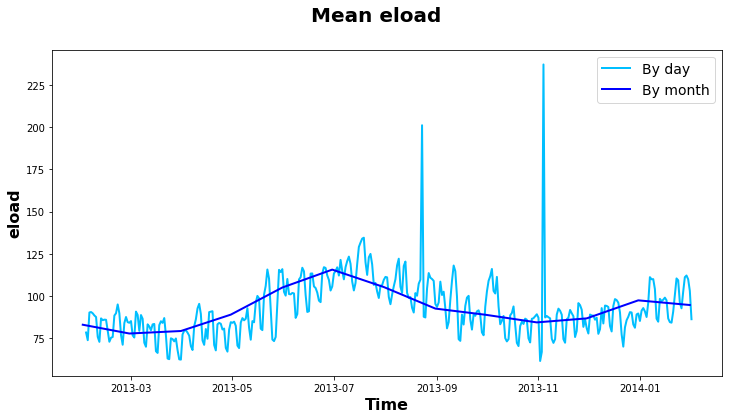

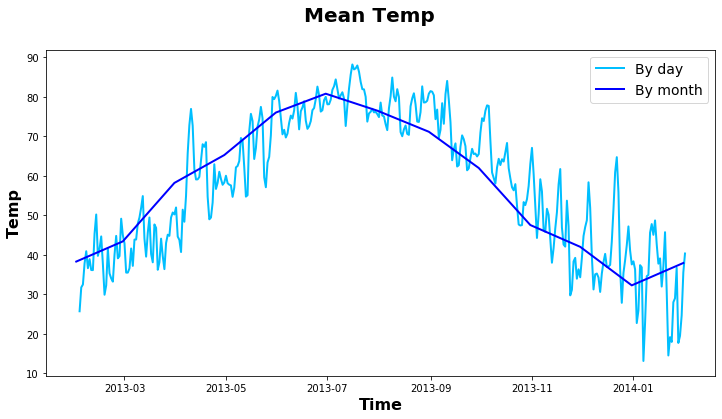

In [12]:
# Run EDA function that visialize data properties 

# 1. plot time series for each parameter
time_series_plot(df)

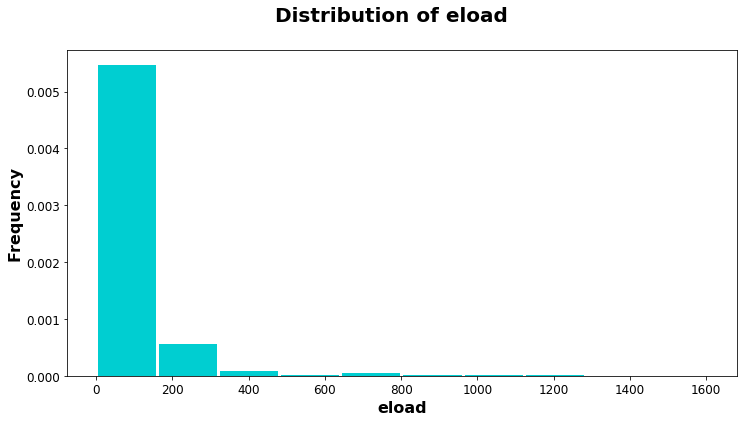

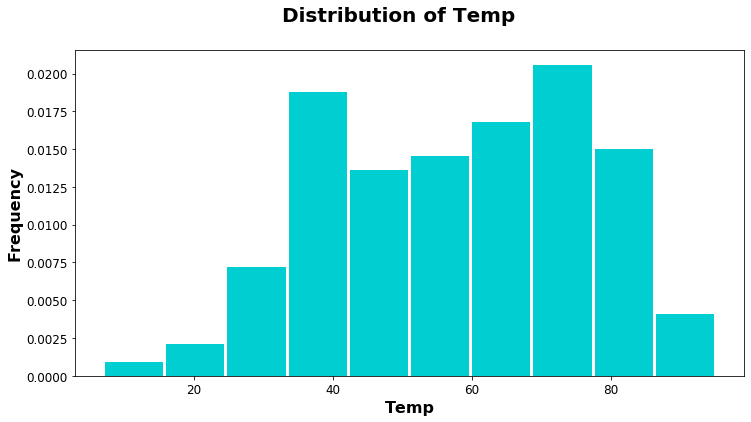

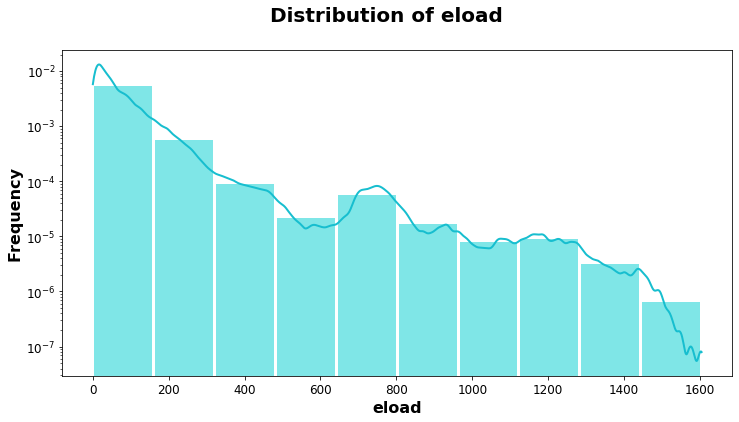

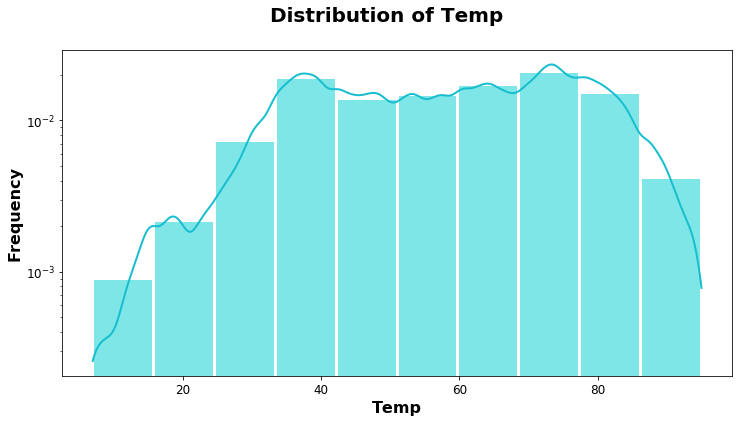

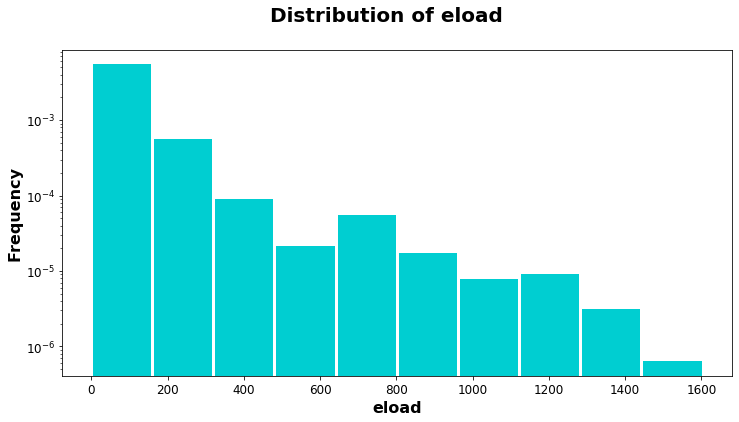

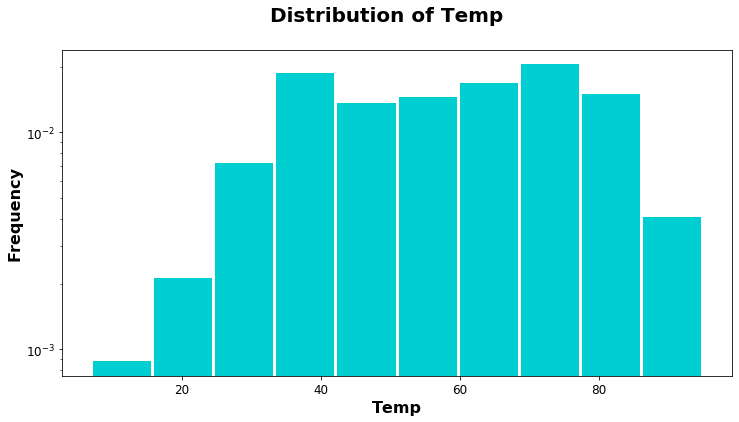

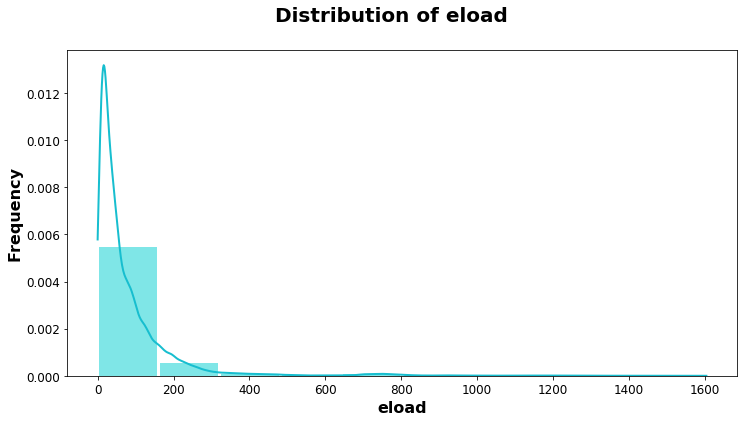

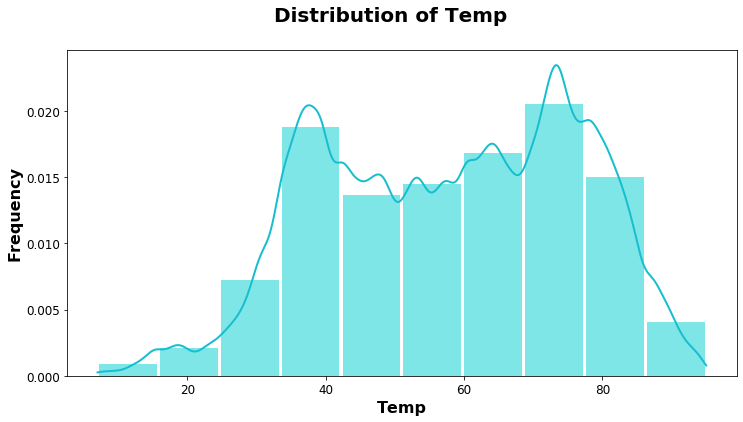

In [19]:
# 2. plot histograms of parameters distribution
plot_histograms(df, show_kde = False, log = False)
plot_histograms(df, show_kde = True, log = True)
plot_histograms(df, show_kde = False, log = True)
plot_histograms(df, show_kde = True, log = False)

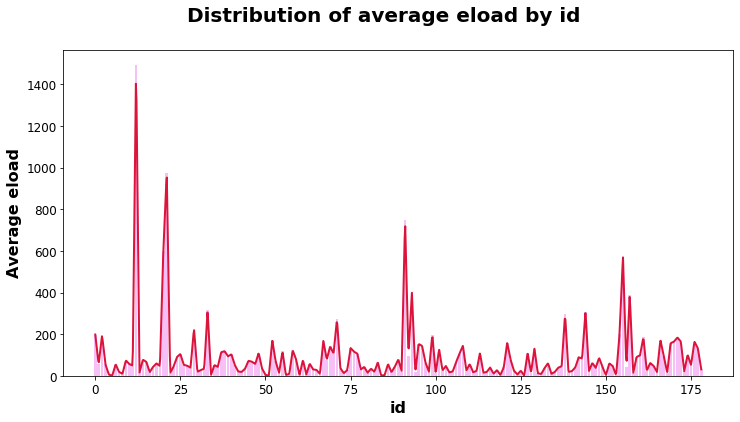

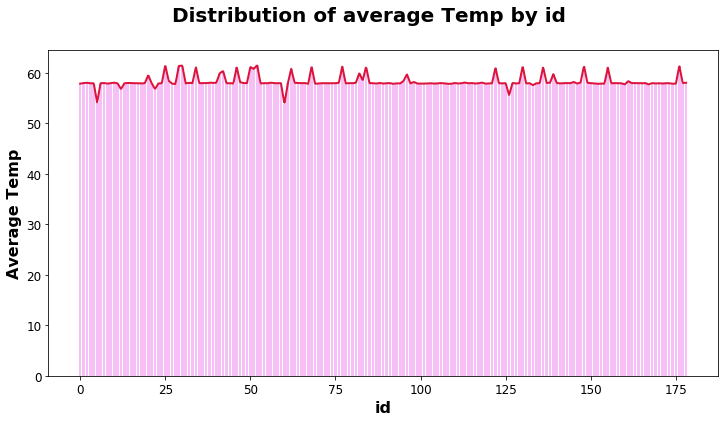

In [13]:
# 3. plot histogram of parameters distribution by id
plot_distribution_by_id(df, interpolate = True)

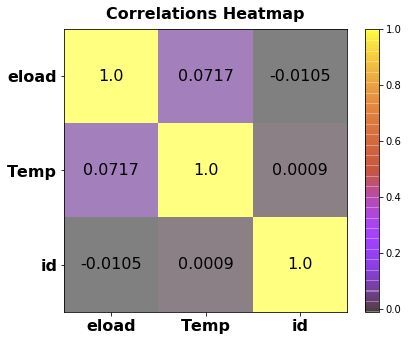

In [31]:
# 4. plot correlation coefficients between data parameters  
plot_correlation_map(df)

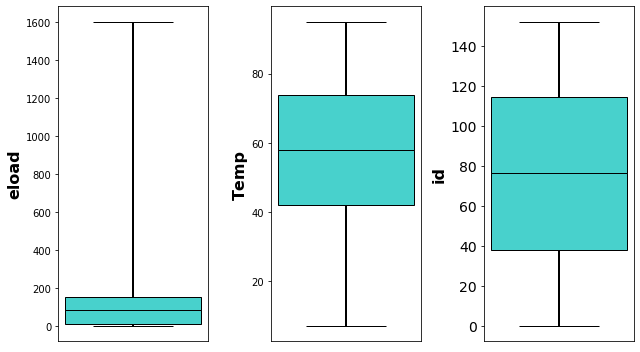

In [24]:
#5. plot parameters range (mean plus/minus standard deviation, minimum, maximum)
range_box_plot(df)

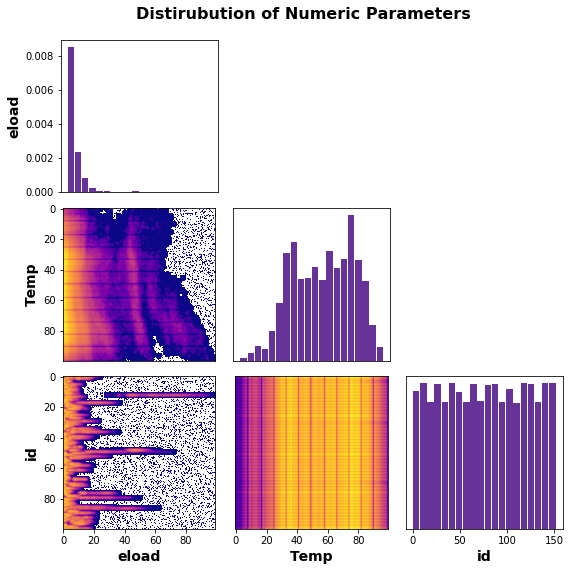

In [32]:
#6. plot joint distribution of all numeric parameters 
plot_joint_parameters_distribution(df)

In [33]:
# create pdf summary
# please make sure that MikTex is installed on your computer 
# https://miktex.org/download

pdf_summary(df)